In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader
import geodatasets
import xarray as xr
import numpy as np
from geopandas import GeoSeries
from pathlib import Path
from pyproj import Transformer
from shapely.geometry import Point , Polygon, MultiPolygon
from shapely.geometry.multipolygon import MultiPolygon
import shapely.wkt
import shapely.geometry
import shapely
from shapely.ops import nearest_points
from pathlib import Path
import rasterio
import rioxarray

In [2]:
trans = gpd.read_file('Data\\trans\\Trans.shp')
trans.crs = {'init': 'epsg:4326'}
trans = trans.to_crs({'init': 'epsg:3857'})

thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]
xr_landuse = xr.open_dataset("Data//dataset-satellite-land-cover//C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2022-01-01')
xr_landuse = xr_landuse.drop_vars('time')

df_landuse_distancetoroad = xr_landuse['lccs_class'].to_dataframe()
df_landuse_distancetoroad.reset_index(inplace=True)
df_landuse_distancetoroad = df_landuse_distancetoroad.rename(columns= {'lccs_class' : 'SI_DtoRoad'})
df_landuse_distancetoroad = gpd.GeoDataFrame(df_landuse_distancetoroad, geometry =gpd.points_from_xy(df_landuse_distancetoroad['lon'],df_landuse_distancetoroad['lat']))
df_landuse_distancetoroad.crs = {'init': 'epsg:4326'}
df_landuse_distancetoroad = df_landuse_distancetoroad.to_crs({'init': 'epsg:3857'})

## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.to_crs({'init': 'epsg:3857'})
boundaries = boundaries.geometry.unary_union

df_distancetoroad = gpd.sjoin_nearest(df_landuse_distancetoroad,trans,distance_col="distance",how='left')

for i in df_distancetoroad.columns:
    if i not in (['lon_left','lat_left','lon','lat','distance','geometry']):
        df_distancetoroad = df_distancetoroad.drop(columns=i)


try: 
    df_distancetoroad = df_distancetoroad.rename(columns= {'lon_left' : 'lon'})
    df_distancetoroad = df_distancetoroad.rename(columns= {'lat_left' : 'lat'})
except:
    None

df_distancetoroad.reset_index(inplace=True,drop=True)

try: 
    df_distancetoroad = df_distancetoroad.drop(columns=['geometry'])
except:
    None

print(df_distancetoroad.columns)
df_distancetoroad = df_distancetoroad.groupby(['lat', 'lon']).agg('mean')
df_distancetoroad.reset_index(inplace=True)
df_distancetoroad = df_distancetoroad.set_index(['lat', 'lon'])
print(df_distancetoroad)

xr_distancetoroad = xr.Dataset.from_dataframe(df_distancetoroad)
print(xr_distancetoroad)

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the prefe

Index(['lat', 'lon', 'distance'], dtype='object')
                           distance
lat       lon                      
5.615278  97.345833   264251.457123
          97.348611   264125.063540
          97.351389   263998.971634
          97.354167   263873.181836
          97.356944   263747.694579
...                             ...
20.462500 105.623611  311942.699695
          105.626389  312124.751040
          105.629167  312307.002429
          105.631944  312489.453510
          105.634722  312672.103935

[15957810 rows x 1 columns]
<xarray.Dataset>
Dimensions:   (lat: 5346, lon: 2985)
Coordinates:
  * lat       (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon       (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    distance  (lat, lon) float64 2.643e+05 2.641e+05 ... 3.125e+05 3.127e+05


In [3]:
df_distancetoroad = xr_distancetoroad.to_dataframe()
df_distancetoroad.reset_index(inplace=True)
df_distancetoroad = gpd.GeoDataFrame(df_distancetoroad, geometry =gpd.points_from_xy(df_distancetoroad['lon'],df_distancetoroad['lat']))

df_distancetoroad['SI_BGEC'] = 0
df_distancetoroad['SI_Biomass'] = 0
df_distancetoroad['SI_Solar'] = 0
df_distancetoroad['SI_Wind'] = 0
df_distancetoroad['SI_BGWW'] = 0
df_distancetoroad['SI_MSW'] = 0
df_distancetoroad['SI_IEW'] = 0

df_distancetoroad['SI_BGEC'].loc[df_distancetoroad['distance'] < (5000)] = 3
df_distancetoroad['SI_BGEC'].loc[(df_distancetoroad['distance'] >= (5000)) & (df_distancetoroad['distance'] <= (10000))] = 2
df_distancetoroad['SI_BGEC'].loc[df_distancetoroad['distance'] > (10000)] = 0

df_distancetoroad['SI_Biomass'].loc[df_distancetoroad['distance'] < (5000)] = 3
df_distancetoroad['SI_Biomass'].loc[(df_distancetoroad['distance'] >= (5000)) & (df_distancetoroad['distance'] <= (10000))] = 2
df_distancetoroad['SI_Biomass'].loc[df_distancetoroad['distance'] > (10000)] = 0

df_distancetoroad['SI_Solar'].loc[df_distancetoroad['distance'] < (5000)] = 3
df_distancetoroad['SI_Solar'].loc[(df_distancetoroad['distance'] >= (5000)) & (df_distancetoroad['distance'] <= (10000))] = 2
df_distancetoroad['SI_Solar'].loc[df_distancetoroad['distance'] > (10000)] = 0

df_distancetoroad['SI_Wind'].loc[df_distancetoroad['distance'] < (5000)] = 3
df_distancetoroad['SI_Wind'].loc[(df_distancetoroad['distance'] >= (5000)) & (df_distancetoroad['distance'] <= (10000))] = 2
df_distancetoroad['SI_Wind'].loc[df_distancetoroad['distance'] > (10000)] = 0

df_distancetoroad['SI_BGWW'].loc[df_distancetoroad['distance'] < (250)] = 0
df_distancetoroad['SI_BGWW'].loc[(df_distancetoroad['distance'] >= (250)) & (df_distancetoroad['distance'] <= (750))] = 1
df_distancetoroad['SI_BGWW'].loc[(df_distancetoroad['distance'] >= (750)) & (df_distancetoroad['distance'] <= (1000))] = 2
df_distancetoroad['SI_BGWW'].loc[df_distancetoroad['distance'] > (1000)] = 3

df_distancetoroad['SI_MSW'].loc[df_distancetoroad['distance'] < (250)] = 0
df_distancetoroad['SI_MSW'].loc[(df_distancetoroad['distance'] >= (250)) & (df_distancetoroad['distance'] <= (750))] = 1
df_distancetoroad['SI_MSW'].loc[(df_distancetoroad['distance'] >= (750)) & (df_distancetoroad['distance'] <= (1000))] = 2
df_distancetoroad['SI_MSW'].loc[df_distancetoroad['distance'] > (1000)] = 3

df_distancetoroad['SI_IEW'].loc[df_distancetoroad['distance'] < (250)] = 0
df_distancetoroad['SI_IEW'].loc[(df_distancetoroad['distance'] >= (250)) & (df_distancetoroad['distance'] <= (750))] = 1
df_distancetoroad['SI_IEW'].loc[(df_distancetoroad['distance'] >= (750)) & (df_distancetoroad['distance'] <= (1000))] = 2
df_distancetoroad['SI_IEW'].loc[df_distancetoroad['distance'] > (1000)] = 3

xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')
df_landuse_suitability_index= xr_landuse_suitability_index.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))

df_distancetoroad['SI_BGEC'].loc[df_landuse_suitability_index['SI_BGEC'] ==  0] = 0
df_distancetoroad['SI_Biomass'].loc[df_landuse_suitability_index['SI_Biomass'] ==  0] = 0
df_distancetoroad['SI_Wind'].loc[df_landuse_suitability_index['SI_Wind'] ==  0] = 0
df_distancetoroad['SI_Solar'].loc[df_landuse_suitability_index['SI_Solar'] ==  0] = 0
df_distancetoroad['SI_BGWW'].loc[df_landuse_suitability_index['SI_BGWW'] ==  0] = 0
df_distancetoroad['SI_MSW'].loc[df_landuse_suitability_index['SI_MSW'] ==  0] = 0
df_distancetoroad['SI_IEW'].loc[df_landuse_suitability_index['SI_IEW'] ==  0] = 0

print(df_distancetoroad)

C:\Users\basna\AppData\Local\Temp\ipykernel_19920\2257197821.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoroad['SI_BGEC'].loc[df_distancetoroad['distance'] < (5000)] = 3
C:\Users\basna\AppData\Local\Temp\ipykernel_19920\2257197821.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoroad['SI_BGEC'].loc[(df_distancetoroad['distance'] >= (5000)) & (df_distancetoroad['distance'] <= (10000))] = 2
C:\Users\basna\AppData\Local\Temp\ipykernel_19920\2257197821.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  264251.457123    POINT (97.34583 5.61528)   
1          5.615278   97.348611  264125.063540    POINT (97.34861 5.61528)   
2          5.615278   97.351389  263998.971634    POINT (97.35139 5.61528)   
3          5.615278   97.354167  263873.181836    POINT (97.35417 5.61528)   
4          5.615278   97.356944  263747.694579    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  311942.699695  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  312124.751040  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  312307.002429  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  312489.453510  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  312672.103935  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_M

C:\Users\basna\AppData\Local\Temp\ipykernel_19920\2257197821.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_distancetoroad['SI_IEW'].loc[df_landuse_suitability_index['SI_IEW'] ==  0] = 0


In [4]:
print(df_distancetoroad)
try: 
    df_distancetoroad = df_distancetoroad.drop(columns=['distance','geometry'])
except:
    None

df_distancetoroad = df_distancetoroad.groupby(['lat', 'lon']).agg('mean')
df_distancetoroad.reset_index(inplace=True)
df_distancetoroad = df_distancetoroad.set_index(['lat', 'lon'])


xr_distancetoroad = xr.Dataset.from_dataframe(df_distancetoroad)
xr_distancetoroad.to_netcdf(path='Output\\xr_SI_Distancetoroad.nc')
print(xr_distancetoroad)

                lat         lon       distance                    geometry  \
0          5.615278   97.345833  264251.457123    POINT (97.34583 5.61528)   
1          5.615278   97.348611  264125.063540    POINT (97.34861 5.61528)   
2          5.615278   97.351389  263998.971634    POINT (97.35139 5.61528)   
3          5.615278   97.354167  263873.181836    POINT (97.35417 5.61528)   
4          5.615278   97.356944  263747.694579    POINT (97.35694 5.61528)   
...             ...         ...            ...                         ...   
15957805  20.462500  105.623611  311942.699695  POINT (105.62361 20.46250)   
15957806  20.462500  105.626389  312124.751040  POINT (105.62639 20.46250)   
15957807  20.462500  105.629167  312307.002429  POINT (105.62917 20.46250)   
15957808  20.462500  105.631944  312489.453510  POINT (105.63194 20.46250)   
15957809  20.462500  105.634722  312672.103935  POINT (105.63472 20.46250)   

          SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  SI_BGWW  SI_M

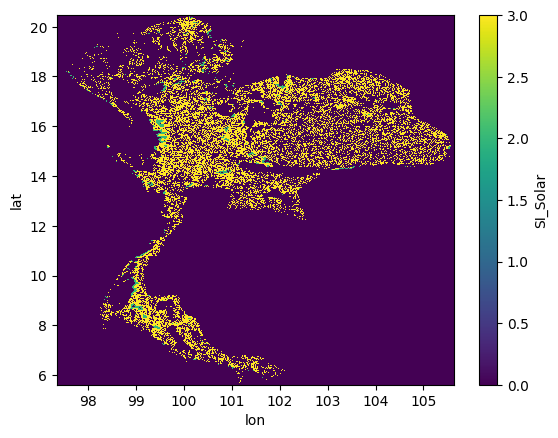

In [5]:
xr_distancetoroad['SI_Solar'].plot()

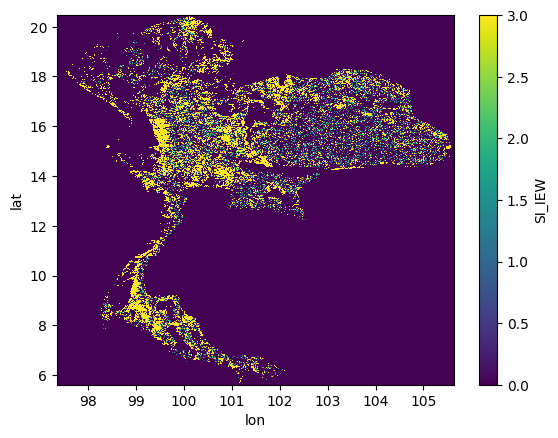

In [6]:
xr_distancetoroad['SI_IEW'].plot()